# **Importing Packages and libraries**

In [5]:
import numpy as np
import pandas as pd
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer , WordNetLemmatizer
import string
import re
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
import gensim.downloader as api
from keras.models import Sequential
from keras.layers import LSTM , Embedding , Dense , GRU , Bidirectional , Flatten , SpatialDropout1D , Dropout
from keras.callbacks import EarlyStopping
import warnings
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings("ignore")
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')

pd.options.display.max_colwidth = 5000

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package stopwords to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package wordnet to

[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


# **Classical ML approach**

## **Importing Data**

In [28]:
twitter_data = pd.read_csv(r"E:\Khaled\Data\Projects\Sentiment_classification\Data\Twitter_Data.csv")
twitter_data.columns = ["Text","Label"]
reddit_data = pd.read_csv(r"E:\Khaled\Data\Projects\Sentiment_classification\Data\Reddit_Data.csv")
reddit_data.columns = ["Text","Label"]
training_data = pd.concat([twitter_data,reddit_data],axis=0)
no_to_categories = {1.0 : "Positive" , 0.0 : "Neutral" , -1.0 : "Negative"}
training_data.Label = training_data.Label.apply(lambda x : no_to_categories.get(x))

In [29]:
training_data = pd.concat([twitter_data,reddit_data],axis=0)

In [30]:
no_to_categories = {1.0 : "Positive" , 0.0 : "Neutral" , -1.0 : "Negative"}
training_data.Label = training_data.Label.apply(lambda x : no_to_categories.get(x))

## **Assessing data**

In [31]:
training_data.head()

,Text,Label
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,Negative
1,talk all the nonsense and continue all the drama will vote for modi,Neutral
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,Positive
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,Positive
4,answer who among these the most powerful world leader today trump putin modi may,Positive


In [32]:
training_data["Label"].value_counts()

Label
Positive    88080
Neutral     68355
Negative    43787
Name: count, dtype: int64

In [33]:
training_data.head(5)

,Text,Label
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,Negative
1,talk all the nonsense and continue all the drama will vote for modi,Neutral
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,Positive
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,Positive
4,answer who among these the most powerful world leader today trump putin modi may,Positive


In [34]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>

Index: 200229 entries, 0 to 37248

Data columns (total 2 columns):

 #   Column  Non-Null Count   Dtype 

---  ------  --------------   ----- 

 0   Text    200125 non-null  object

 1   Label   200222 non-null  object

dtypes: object(2)

memory usage: 4.6+ MB


In [35]:
training_data.isna().any()

Text     True
Label    True
dtype: bool

In [36]:
training_data.duplicated().sum()

511

In [37]:
training_data.isna().sum()

Text     104
Label      7
dtype: int64

Since the duplicates and nans represents a very small portion of the data then i'll drop them.

In [38]:
training_data.dropna(inplace= True)
training_data.drop_duplicates(inplace=True)

## **EDA**

In [39]:
training_data.shape

(199708, 2)

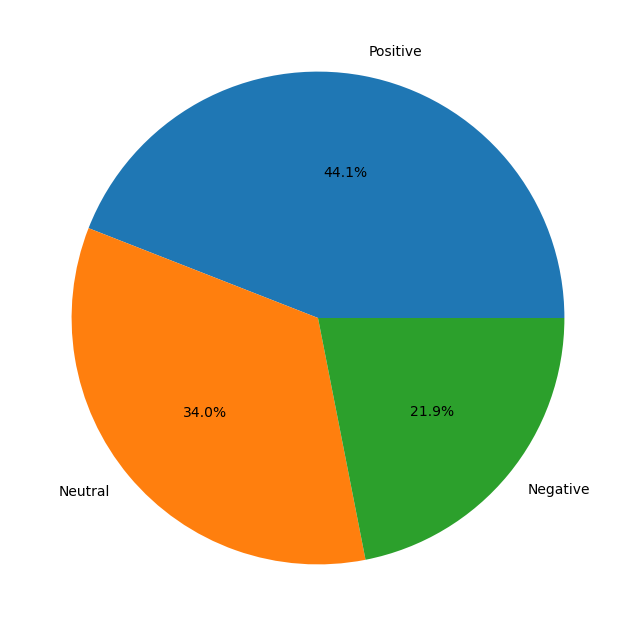

In [40]:
category_perecntage = (100*training_data.Label.value_counts()/len(training_data)).to_frame().reset_index()

plt.figure(figsize=(16,8))
plt.pie(category_perecntage["count"],labels = category_perecntage["Label"] , autopct = "%1.1f%%") ;

Since there's a significant imbalance in the dataset, then I'll apply undersampling.

In [41]:
undersampler = RandomUnderSampler()

# Undersample the majority class
X_resampled, y_resampled = undersampler.fit_resample(training_data[['Text']], training_data['Label'])
y_resampled = pd.DataFrame({'Label': y_resampled})
training_data = pd.concat([X_resampled,y_resampled],axis=1)

Now let's focus on the no of tokens in each comment

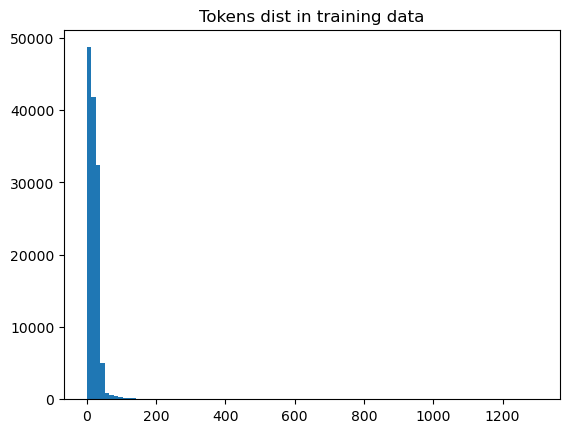

In [42]:
training_data["#tokens"] = training_data["Text"].apply(lambda x : len(x.split()))
plt.title("Tokens dist in training data")
plt.hist(training_data["#tokens"],bins=100)
plt.show()

Let's see the average number of tokens for every class.

Text(0.5, 1.0, 'Average no of tokens in category')

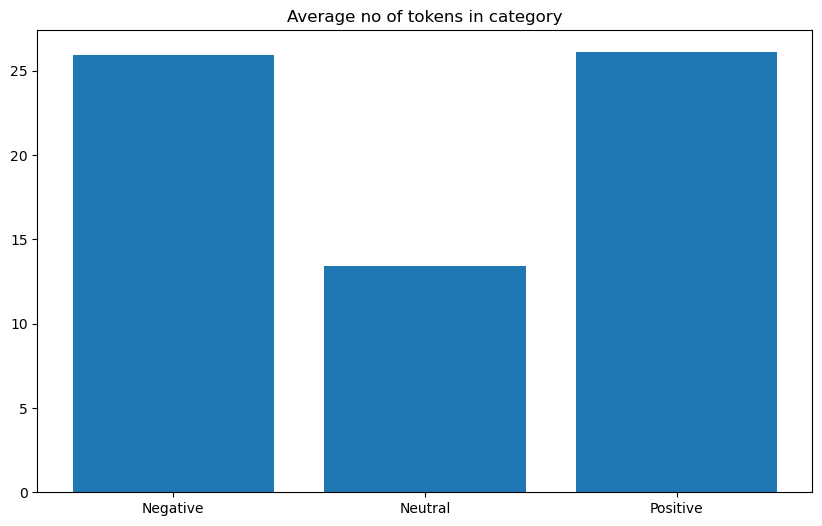

In [43]:
categories_tokens = training_data.groupby("Label")["#tokens"].mean().to_frame().reset_index()

plt.figure(figsize=(10,6))
plt.bar(data= categories_tokens , height = "#tokens" , x ="Label") ;
plt.title("Average no of tokens in category")

## **Prprocessing Text**

In [44]:
def preprocess_text(text):
    # Convert text to lowercase , Remove punctuation and characters
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # Remove stopwords
    english_stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in word_tokenize(text) if word not in english_stop_words])

    # Stemming
    ps = nltk.stem.porter.PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])
    #text = ' '.join([ps.stem(word) for word in word_tokenize(text)])

    return text

In [45]:
training_data["Text"] = training_data["Text"].apply(lambda x : preprocess_text(x))

## **Splitting Data**

In [46]:
y_train = training_data["Label"]
x_train = training_data["Text"]
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train,test_size = .05,random_state = 42)

In [47]:
labels_encoder = LabelEncoder()
labels_encoder.fit(y_train)
y_train = labels_encoder.transform(y_train)
y_valid = labels_encoder.transform(y_valid)

## **Modeling**

In [48]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 1), stop_words='english')

In [49]:
def get_acc_score(model, training_data, validation_data):
    """
    Calculate the training and validation accuracy scores for a given model.

    Args:
    - model (object): The machine learning model to evaluate.
    - training_data (tuple): A tuple containing the training features and labels (x_t, y_t).
    - validation_data (tuple): A tuple containing the validation features and labels (x_v, y_v).

    Returns:
    - training_acc (float): The accuracy score on the training set.
    - validation_acc (float): The accuracy score on the validation set.
    """
    x_t, y_t = training_data
    x_v, y_v = validation_data

    # Fit TF-IDF vectorizer to training data and transform both training and validation data
    tfidf_vectorizer.fit(x_t)
    x_t = tfidf_vectorizer.transform(x_t)
    x_v = tfidf_vectorizer.transform(x_v)

    # Train the model on the transformed training data
    model.fit(x_t, y_t)

    # Predict labels for both training and validation data
    y_t_predicted = model.predict(x_t)
    y_v_predicted = model.predict(x_v)

    # Calculate accuracy scores for both training and validation data
    training_acc = accuracy_score(y_t_predicted, y_t)
    validation_acc = accuracy_score(y_v_predicted, y_v)

    return training_acc, validation_acc

In [50]:
models = {"Logistic Regression model" : LogisticRegression(multi_class = 'multinomial' , solver = 'sag'),
          "SGD model" : SGDClassifier(),
          "RandomForest Classifier": RandomForestClassifier(n_estimators=50),
          "GradientBoosting Classifer" : GradientBoostingClassifier(),
          "XGboost" : xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42, device = "cuda")
         }

In [51]:
for model_name , model in models.items() :

    train_score , val_score = get_acc_score(model, (x_train,y_train), (x_valid,y_valid))
    print(f"{model_name} scores :\nTraining score : {train_score}\nValidation_score : {val_score}\n\n","#"*50,"\n")

Logistic Regression model scores :

Training score : 0.8889664076470919

Validation_score : 0.8465874466788543



 ################################################## 



SGD model scores :

Training score : 0.8159838333293238

Validation_score : 0.79981718464351



 ################################################## 



RandomForest Classifier scores :

Training score : 0.9987730651718911

Validation_score : 0.8124619134673979



 ################################################## 



GradientBoosting Classifer scores :

Training score : 0.6957923352659562

Validation_score : 0.6980499695307739



 ################################################## 



XGboost scores :

Training score : 0.34631638880201443

Validation_score : 0.35390006093845217



 ################################################## 




It's obvious that the logistic regression model has the best scores on the training & validation sets.

Now that we've tried the classical ML models, let's see how the performance will change if we use RNNs instead.

let's start over with a  new instance of the provided data

# **RNN approach**

## **Importing Data**

In [6]:
twitter_data = pd.read_csv(r"E:\Khaled\Data\Projects\Sentiment_classification\Data\Twitter_Data.csv")
twitter_data.columns = ["Text","Label"]
reddit_data = pd.read_csv(r"E:\Khaled\Data\Projects\Sentiment_classification\Data\Reddit_Data.csv")
reddit_data.columns = ["Text","Label"]
training_data = pd.concat([twitter_data,reddit_data],axis=0)

## **Preprocessing text**

In [7]:
training_data.dropna(inplace= True)
training_data.drop_duplicates(inplace=True)

undersampler = RandomUnderSampler()

# Undersample the majority class
X_resampled, y_resampled = undersampler.fit_resample(training_data[['Text']], training_data['Label'])
y_resampled = pd.DataFrame({'Label': y_resampled})
training_data = pd.concat([X_resampled,y_resampled],axis=1)

no_to_categories = {1.0 : "Positive" , 0.0 : "Neutral" , -1.0 : "Negative"}
training_data.Label = training_data.Label.apply(lambda x : no_to_categories.get(x))

In [8]:
# Extract the "Text" column from the training_data DataFrame and convert it to a DataFrame with the column name "Text"
x_train = training_data["Text"].to_frame(name="Text").reset_index(drop=True)

# Extract the labels from the training_data DataFrame
y_train = training_data["Label"]

# Initialize a LabelEncoder object
labels_encoder = LabelEncoder()

# Fit the LabelEncoder to the labels in y_train
labels_encoder.fit(y_train)

# Transform the labels in y_train into encoded integer labels
y_train = labels_encoder.transform(y_train)

In [9]:
def preprocess_text(text):
    # Convert text to lowercase , Remove punctuation and characters
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # Remove stopwords
    english_stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in word_tokenize(text) if word not in english_stop_words])

    # Stemming
    ps = nltk.stem.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])

    return text

In [10]:
# Apply a preprocessing function to each text in the "Text" column of the x_train DataFrame
x_train["Text"] = x_train["Text"].apply(lambda x : preprocess_text(x))

In [11]:
# Calculate the average length of tokens (words) in the text data
tokens_avg_length = x_train["Text"].apply(lambda x : len(x.split())).mean()
print(f"Tokens average length = {tokens_avg_length}")

Tokens average length = 15.32230983125738


In [12]:
x_train , x_test , y_train , y_test = train_test_split(x_train,y_train,test_size = .05,random_state = 42)

In [13]:
# i'll set the max length to 50 to make sure that the model get's enough info to classify the text
max_length = 50

# Create a Tokenizer object
tokenizer = Tokenizer()

# Fit the tokenizer on the text data from the "Text" column of x_train
tokenizer.fit_on_texts(x_train["Text"].to_list())

# Convert the text data from the "Text" column of x_train to sequences of integers
sequences = tokenizer.texts_to_sequences(x_train["Text"].to_list())

# Pad sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [14]:
#glove_model = api.load("word2vec-google-news-300")
glove_model = api.load("glove-wiki-gigaword-100")
#glove_model = api.load("glove-twitter-25")

In [15]:
# Set the dimensionality of the embedding vectors
embedding_dim = 100


# Calculate the size of the vocabulary, including the reserved index 0
vocab_size = len(tokenizer.word_index) + 1

# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [16]:
# Iterate over each word and its corresponding index in the tokenizer's word index dictionary
for word, i in tokenizer.word_index.items():
    # Check if the word is present in the pre-trained Word2Vec model
    if word in glove_model:
        # If the word is present, assign its pre-trained embedding vector to the corresponding row in the embedding matrix
        embedding_matrix[i] = glove_model[word]

## **RNN modeling**

In [17]:
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    SpatialDropout1D(0.3),  # Spatial dropout for the embedding layer
    Bidirectional(LSTM(50, return_sequences=True)),
    Dropout(0.5),  # Dropout for regularization
    Flatten(),
    Dropout(0.5),  # Dropout for regularization
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [18]:
# Define early stopping criteria
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# callbacks=[early_stopping]

model.fit(padded_sequences, y_train, epochs=5, batch_size=16, validation_split=0.05)

Epoch 1/5

7405/7405 ━━━━━━━━━━━━━━━━━━━━ 508s 68ms/step - accuracy: 0.7280 - loss: 0.6448 - val_accuracy: 0.8488 - val_loss: 0.4188

Epoch 2/5

7405/7405 ━━━━━━━━━━━━━━━━━━━━ 477s 64ms/step - accuracy: 0.8710 - loss: 0.3737 - val_accuracy: 0.8473 - val_loss: 0.4355

Epoch 3/5

7405/7405 ━━━━━━━━━━━━━━━━━━━━ 492s 66ms/step - accuracy: 0.8982 - loss: 0.2935 - val_accuracy: 0.8406 - val_loss: 0.4642

Epoch 4/5

7405/7405 ━━━━━━━━━━━━━━━━━━━━ 472s 64ms/step - accuracy: 0.9210 - loss: 0.2297 - val_accuracy: 0.8260 - val_loss: 0.5231

Epoch 5/5

7405/7405 ━━━━━━━━━━━━━━━━━━━━ 509s 69ms/step - accuracy: 0.9372 - loss: 0.1855 - val_accuracy: 0.8262 - val_loss: 0.6011


The model starts strong with significant improvements in accuracy up to the second epoch. However, after that, while training accuracy keeps rising, validation accuracy plateaus and then slightly decreases, indicating possible overfitting. Increasing the dropout ratio could help address this issue, along with exploring data augmentation.

# **BERT approach**

## **Importing Packages**

In [14]:
import pandas as pd
import numpy as np
import torch
from torch import nn , optim
from transformers import BertTokenizer, BertModel , get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertModel
import torch.nn.functional as f
from collections import defaultdict
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler

## **Importing Data**

In [15]:
twitter_data = pd.read_csv(r"/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv")
twitter_data.columns = ["Text","Label"]
reddit_data = pd.read_csv(r"/kaggle/input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv")
reddit_data.columns = ["Text","Label"]
training_data = pd.concat([twitter_data,reddit_data],axis=0)

In [16]:
training_data.dropna(inplace= True)
training_data.drop_duplicates(inplace=True)

undersampler = RandomUnderSampler()

# Undersample the majority class
X_resampled, y_resampled = undersampler.fit_resample(training_data[['Text']], training_data['Label'])
y_resampled = pd.DataFrame({'Label': y_resampled})
training_data = pd.concat([X_resampled,y_resampled],axis=1)

no_to_categories = {1.0 : "Positive" , 0.0 : "Neutral" , -1.0 : "Negative"}
training_data.Label = training_data.Label.apply(lambda x : no_to_categories.get(x))

In [17]:
# Check the number of CUDA-compatible GPUs
num_gpus = torch.cuda.device_count()
print("Number of available CUDA-compatible GPUs:", num_gpus)

# Print information about each CUDA device
for i in range(num_gpus):
    print("CUDA Device:", i)
    print(torch.cuda.get_device_name(i))

Number of available CUDA-compatible GPUs: 1
CUDA Device: 0
Tesla P100-PCIE-16GB


In [18]:
MAX_LEN = 100
BATCH_SIZE = 16
RANDOM_SEED = 42
EPOCHS = 4
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Data Loader**

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
class ReviewDataset(Dataset) :
  def __init__(self,reviews,targets,max_len,tokenizer) :
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self) :
    return len(self.reviews)

  def __getitem__(self,item) :
    review = str(self.reviews[item])
    target = self.targets[item]
    encodings = tokenizer.encode_plus(
        review,
        add_special_tokens = True ,
        truncation = True ,
        max_length = self.max_len,
        padding="max_length",
        return_token_type_ids = False,
        return_attention_mask = True ,
        return_tensors = "pt" )

    return{"review" : review ,
           "input_ids" :  encodings["input_ids"].flatten() ,
           "attention_mask" : encodings["attention_mask"].flatten(),
           "targets" : torch.tensor(target , dtype=torch.long)}

In [21]:
senitment_int = {"Positive" : 0 , "Negative" : 1 , "Neutral" : 2 }
training_data["senitment_int"] = training_data["Label"].map(senitment_int)

In [22]:
training_data , testing_data = train_test_split(training_data, test_size=0.05, random_state=RANDOM_SEED)
validation_data , testing_data = train_test_split(training_data, test_size=0.5, random_state=RANDOM_SEED)

In [23]:
def create_data_loader(df , tokenizer , max_len , batch_size) :
  df = ReviewDataset(
      reviews = df.Text.to_numpy(),
      targets = df.senitment_int.to_numpy(),
      tokenizer = tokenizer ,
      max_len = max_len
  )

  return DataLoader(df , batch_size = batch_size , num_workers = 0)

In [24]:
train_data_loader = create_data_loader(training_data , tokenizer , MAX_LEN , BATCH_SIZE)
test_data_loader= create_data_loader(testing_data , tokenizer , MAX_LEN , BATCH_SIZE)
val_data_loader = create_data_loader(validation_data , tokenizer , MAX_LEN , BATCH_SIZE)

## **Building Model**

In [25]:
class SenitmentClassifier(nn.Module) :
  def __init__(self,n_classes) :
    super(SenitmentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p= 0.4)
    self.out = nn.Linear(self.bert.config.hidden_size , n_classes)


  def forward(self,input_ids,attention_mask) :
    pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
    )
    output = self.drop(pooled_output[1])
    return self.out(output)

In [26]:
model = SenitmentClassifier(len(senitment_int))
model = model.to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [27]:
training_steps = EPOCHS * len(train_data_loader)
optimizer = AdamW(model.parameters(),lr=2e-5)


scheduler = get_linear_schedule_with_warmup(optimizer , num_warmup_steps = 0 , num_training_steps = training_steps)

loss_fn = nn.NLLLoss().to(device)

In [28]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader) :
    inputs_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    output = model(inputs_ids,attention_mask)

    _,preds = torch.max(output,dim=1)


    correct_predictions += torch.sum(preds==targets)
    loss = loss_fn(output,targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


  return correct_predictions.double() / n_examples , np.mean(losses)

In [29]:
def eval_model(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):

  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad() :
    for d in tqdm(data_loader) :
      inputs_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      output = model(inputs_ids,attention_mask)
      _,preds = torch.max(output,dim=1)

      correct_predictions += torch.sum(preds==targets)
      loss = loss_fn(output,targets)
      losses.append(loss.item())


  return correct_predictions.double() / n_examples , np.mean(losses)

## **Model Training**

In [30]:
best_accuracy = 0
history = defaultdict(list)

for epoch in range(EPOCHS) :
  print(f"Epoch {epoch+1} of {EPOCHS}")
  print("-"*50)
  
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))
  print(f"Training accuracy : {train_acc}\nTraining loss : {train_loss}")
  
  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, optimizer, device, scheduler, len(validation_data))
  print(f"Validation accuracy : {val_acc}\nValidation loss : {val_loss}\n")

  history["training accuracy"].append(train_acc)
  history["training loss"].append(train_loss)
  history["validation accuracy"].append(val_acc)
  history["validation loss"].append(val_loss)

  if val_acc > best_accuracy :
    best_accuracy = val_acc
    torch.save(model.state_dict(),"best_model_state.bin")

Epoch 1 of 4
--------------------------------------------------


100%|██████████| 7794/7794 [21:02<00:00,  6.18it/s]


Training accuracy : 0.7665776537477647
Training loss : -55.56347914884947


100%|██████████| 3897/3897 [04:15<00:00, 15.23it/s]


Validation accuracy : 0.8906495589414596
Validation loss : -99.32005550080089

Epoch 2 of 4
--------------------------------------------------


100%|██████████| 7794/7794 [21:01<00:00,  6.18it/s]


Training accuracy : 0.8799207704829953
Training loss : -133.94553646002484


100%|██████████| 3897/3897 [04:16<00:00, 15.19it/s]


Validation accuracy : 0.9043143544506816
Validation loss : -164.4906560453905

Epoch 3 of 4
--------------------------------------------------


100%|██████████| 7794/7794 [21:00<00:00,  6.18it/s]


Training accuracy : 0.8977794885365795
Training loss : -186.3437458358424


100%|██████████| 3897/3897 [04:15<00:00, 15.27it/s]


Validation accuracy : 0.9085966319165999
Validation loss : -203.85928315360147

Epoch 4 of 4
--------------------------------------------------


100%|██████████| 7794/7794 [20:59<00:00,  6.19it/s]


Training accuracy : 0.9058548046928252
Training loss : -212.60670385049923


100%|██████████| 3897/3897 [04:15<00:00, 15.23it/s]


Validation accuracy : 0.9164875701684042
Validation loss : -217.1935355539104



## **Model Testing**

In [31]:
test_acc , _ = eval_model(model,test_data_loader,loss_fn,optimizer,device,scheduler,len(testing_data))
print(f"Testing accuracy : {test_acc}")

100%|██████████| 3897/3897 [04:16<00:00, 15.21it/s]

Testing accuracy : 0.9170342095555806


 It's obvious that the fine-tuned BERT model has better performance (accuracy score = 91.7%) than DL and classical ML solutions.